In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit

The end goal of the analysis is to determine the mass of the neutron using the Bohr model of the atom. This will require using measured values from the Hydrogen-Deuterium spectrum. In order to increase accuracy we first need to calibrate the values of our observed Hydrogen-Deuterium spectrum with a calibration curve derived from comparing our lab-observed spectrum of Neon to the accepted values. In order to find accurate values to fit a calibration curve to we perform Guassian fits around the peaks in the spectrum and take the centers of the fits as the peak wavelengths. The exraction of the peak values is below.

(rows,columns) = (3648, 2)


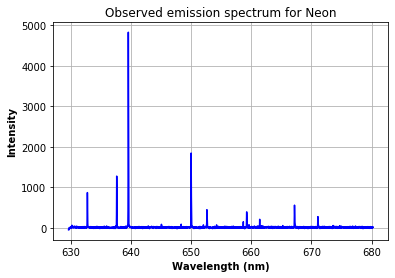

In [4]:
#Loading and plotting neon spectrum data
neon = np.loadtxt("data/neon.txt")
print("(rows,columns) =",np.shape(neon))
neon_plot = plt.plot(neon[:,0], neon[:,1], "-b")
plt.xlabel("Wavelength (nm)",fontweight="bold")
plt.ylabel("Intensity", fontweight="bold")
plt.title("Observed emission spectrum for Neon")
plt.grid()
plt.show()

In order to fit Gaussian curves to the peaks in the Neon spectrum the data needs to be spliced into sets containing only one peak. The question of how many points around each peak to take has implications in the accuracy of the calibration curve fit. For now, we will try to take an equal amount of points around each peak subject to the condition that each set must only contain one peak.

In [5]:
#Initializing data structures
peak_indices=[]
intensities = neon[:,1]
wavelengths = neon[:,0]
threshold = 100

#Naive peak finder based on observations of data
#This will give the indices corresponding to the extent of the gaussian peaks
for i in range(len(intensities)):
    if intensities[i] > threshold:
        peak_indices.append(i)

#Extracting singular peaks by averaging like intervals with intensity above threshold
#This needs to be refactored into an iterative approach
peak_1 = np.mean(np.array(peak_indices[:6]))
peak_2 = np.mean(np.array(peak_indices[7:12]))
peak_3 = np.mean(np.array(peak_indices[13:21]))
peak_4 = np.mean(np.array(peak_indices[22:31]))
peak_5 = np.mean(np.array(peak_indices[32:40]))
peak_6 = np.mean(np.array(peak_indices[41:50]))
peak_7 = np.mean(np.array(peak_indices[51:61]))
peak_8 = np.mean(np.array(peak_indices[62:67]))

avg_peaks = [peak_1,peak_2,peak_3,peak_4,peak_5,peak_6,peak_7,peak_8]

#Splitting data around average peaks into list of lists of both wavelengths and intensities
#Each wavelength-intensity list pair will be used to fit
intensity_intervals = []
wavelength_intervals = []
for i in range(len(avg_peaks)):
    range_bot = math.floor(avg_peaks[i])-25
    range_top = math.floor(avg_peaks[i])+25
    intensity_intervals.append(intensities[range_bot:range_top])
    wavelength_intervals.append(wavelengths[range_bot:range_top])

In [6]:
#Defining gaussian function to be fit to
def f(x,a,m,sd):
    gaussian = a*np.exp(-np.power(x - m, 2.) / (2 * np.power(sd, 2.)))
    return gaussian

#Vectorizing function definition for curve fit
fit_function = np.vectorize(f)   

#Performing curve fitting over each peak and storing optimal parameters in fit_params
fit_params = []
for i in range(len(intensity_intervals)):
    #Picking the x and y values for each peak from our list of peaks
    temp_wavelengths = wavelength_intervals[i]
    temp_intensities = intensity_intervals[i]
    #Defining reasonable initial parameter guesses
    p0 = [np.max(temp_intensities), temp_wavelengths[np.argmax(temp_intensities)], .1]
    params, fit_covs = curve_fit(fit_function, temp_wavelengths, temp_intensities, p0, maxfev = 5000)
    fit_params.append(params)
    print(params)

[8.74505371e+02 6.32802827e+02 2.54825674e-02]
[1.35271571e+03 6.37671837e+02 2.09523045e-02]
[4.98800270e+03 6.39600570e+02 2.34957053e-02]
[1.77919608e+03 6.50030178e+02 3.06620678e-02]
[4.08800223e+02 6.52661850e+02 3.30585936e-02]
[3.71737265e+02 6.59265354e+02 3.23064392e-02]


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.

I've been unable to fix this runtime error. The fit seems to converge to reasonable values so I will use it for now. This may have something to do with the way the gaussian is defined.

Now that we've fit gaussians to each peak in the neon spectrum we can extract the mean of each peak which correspond to our observed wavelengths and compare them to the theoretical wavelengths to obtain a calibration curve

In [7]:
#Collecting peak wavelengths from Neon fits into a list
obs_peaks = []
for i in range(len(fit_params)):
    temp_list = fit_params[i]
    obs_peaks.append(temp_list[1])
    
print(obs_peaks)

[632.8028265389839, 637.6718366874209, 639.6005701011945, 650.0301781687637, 652.6618497078647, 659.2653540307347]


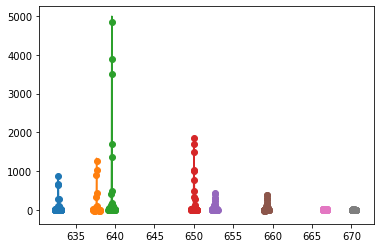

In [8]:
#Generating scatter plots
scatter_plots = []
for i in range(len(intensity_intervals)):
    #Accessing individual interval data and plotting it
    temp_wavelengths = wavelength_intervals[i]
    temp_intensities = intensity_intervals[i]
    scatter_plots.append(plt.scatter(temp_wavelengths, temp_intensities))

#Generating fit plots
fit_plots = []
for j in range(len(fit_params)):
    #Accessing fit parameters for each interval
    temp_params = fit_params[j]
    a = temp_params[0]
    m = temp_params[1]
    sd = temp_params[2]
    #Creating x data based on x data of interval
    temp_wavelengths = wavelength_intervals[j]
    x = np.linspace(np.amin(temp_wavelengths), np.amax(temp_wavelengths))
    #Creating y data iteratively (as opposed to vectorized approach)
    y = []
    
    for k in range(len(x)):
        y.append(f(x[k],a,m,sd))
    fit_plots.append(plt.plot(x,y))

Now that we have performed the fits on the neon spectrum and extracted the mean values we can use these to perform a calibration fit with the accepted values. Upon inspection of the last two peaks, they seem to be almost indistinguishable from the intensity noise background so we will omit them from our calibration.

In [9]:
#Defining list of accepted peak values corresponding to observed peak values
acc_peaks = [632.816, 638.299, 640.225, 650.653, 653.288, 659.895]

In [10]:
#Defining line to fit to
def line(x,m,b):
    y = m*x+b
    return y
#Vectorizing function
line_to_fit = np.vectorize(line)
#Initial guesses
p0 = (1,0)
#Curve fit
calib_params, calib_covs = curve_fit(line_to_fit, obs_peaks, acc_peaks, p0)
print("slope = ", calib_params[0], " intercept = ", calib_params[1] )
print("covariances = ", calib_covs)

slope =  1.0148895489956915  intercept =  -9.084905762069905
covariances =  [[ 9.55237787e-05 -6.16451930e-02]
 [-6.16451930e-02  3.97902839e+01]]


Scipy.optimize.curve_fit returns a covariance matrix ofr assesing the quality of the fits. In roder to extract the standard error for each paramter we take the square root of the diagonals (which gives the standard deviation) and then we divide each by the number of samples to obtain the standard error.

In [11]:
#Obtaining standard error for the calibration fit
std_deviations = []
for i in range(len(calib_covs)):
    temp_array = calib_covs[i]
    std_deviations.append(math.sqrt(temp_array[i]))

std_errors = []
for i in range(len(std_deviations)):
    std_errors.append(std_deviations[i]/len(obs_peaks))
    
print("standard errors for slope and intercept: ", std_errors)

standard errors for slope and intercept:  [0.0016289377820490065, 1.0513256694354667]


Observed peaks:  [632.8028265389839, 637.6718366874209, 639.6005701011945, 650.0301781687637, 652.6618497078647, 659.2653540307347]
Accepted peaks:  [632.816, 638.299, 640.225, 650.653, 653.288, 659.895]


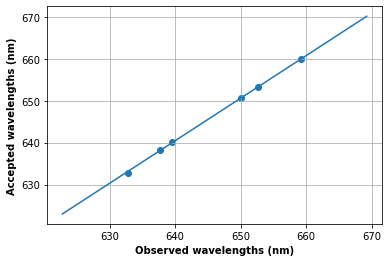

In [19]:
#Plotting calibration curve
#Cutting out overly noisy peaks
obs_peaks = obs_peaks[:6]
print("Observed peaks: ", obs_peaks)
print("Accepted peaks: ", acc_peaks)
plt.scatter(obs_peaks, acc_peaks)

x = np.linspace(np.amin(obs_peaks)-10, np.amax(obs_peaks)+10)
y = []
for i in range(len(x)):
    y.append(line(x[i], calib_params[0], calib_params[1]))
plt.plot(x,y)
plt.xlabel("Observed wavelengths (nm)", fontweight="bold")
plt.ylabel("Accepted wavelengths (nm)", fontweight="bold")
plt.grid()

Now that we have the calibration curve we can use it to transform the data for the Hydrogen-Deuterium spectrum for a final analysis

(rows,columns) = (3648, 2)


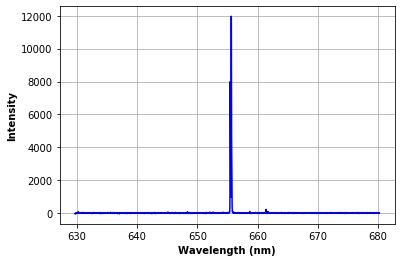

In [13]:
#Loading and plotting the Hydrogen-Deuterium data
hd = np.loadtxt("data/Hydrogen-Deuterium.txt")
print("(rows,columns) =",np.shape(hd))
neon_plot = plt.plot(hd[:,0], hd[:,1], "-b")
plt.xlabel("Wavelength (nm)",fontweight="bold")
plt.ylabel("Intensity", fontweight="bold")
plt.grid()
plt.show()

In [14]:
#Transforming the data according to the calibration curve
hd_intensities = hd[:,1]
hd_wavelengths = hd[:,0]
calibrated_data = line_to_fit(hd_wavelengths, calib_params[0], calib_params[1])

In [15]:
#Performing double gaussian fit to calibrated data
def double_gaussian(x, a1, a2, m1, m2, sd1, sd2):
    double_gauss = a1*np.exp(-np.power(x - m1, 2.) / (2 * np.power(sd1, 2.)))+a2*np.exp(-np.power(x - m2, 2.) / (2 * np.power(sd2, 2.)))
    return double_gauss

#Vectorizing function
double_gauss_to_fit = np.vectorize(double_gaussian)
#Initial guesses
p0 = (5000,5000,655, 656, .1,.1)
#Curve fit
hd_params, hd_covs = curve_fit(double_gauss_to_fit, calibrated_data, hd_intensities, p0)
print(hd_params)

[ 1.13944920e+04  7.41286403e+03  6.56324365e+02  6.56145602e+02
  3.49967831e-02 -3.18831302e-02]


In [16]:
#Calculating the standard error in the parameters from the covariance
hd_std_errors = []
for i in range(len(hd_covs)):
    temp_list = hd_covs[i]
    hd_std_errors.append(math.sqrt(temp_list[i]))
print(hd_std_errors)

[48.3866198395409, 48.50251462743127, 0.00016990245071777987, 0.00025207662300022325, 0.00016588199146856726, 0.0002516541202912401]


Text(0, 0.5, 'Intensity')

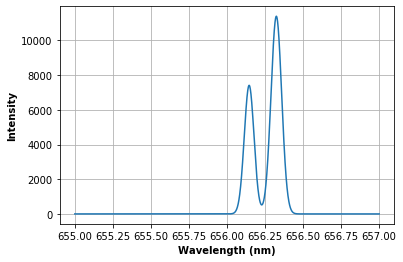

In [17]:
#Plotting the fit curve
x = np.linspace(655,657, num=2000)
y=[]
for i in range(len(x)):
    y.append(double_gaussian(x[i], hd_params[0], hd_params[1], hd_params[2], hd_params[3], hd_params[4], hd_params[5]))

plt.plot(x,y)
plt.grid()
plt.xlabel("Wavelength (nm)", fontweight="bold")
plt.ylabel("Intensity", fontweight="bold")

In [18]:
#Calculating difference by hand avoids loss of significance 
mean_1 = hd_params[2]
mean_2 = hd_params[3]
print(mean_1, mean_2)

656.3243654122056 656.145602449952
